In [1]:
!pwd
%cd /media/laptq/data/workspace/hello-gen-ai

/media/laptq/data/workspace/hello-gen-ai/notebooks
/media/laptq/data/workspace/hello-gen-ai


/media/laptq/data/workspace/hello-gen-ai/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!export CUDA_VISIBLE_DEVICES=0

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
# from torch.autograd.variable import Variable

In [4]:
BATCHSIZE = 128
STEP_SIZE = 400
LR = 0.0002
EPOCHS = 200
DEVICE = 'cuda:0'
N_HIDDENS = 8
N_LABELS = 10

Some [GAN hacks](https://github.com/soumith/ganhacks):

1. Input should be normalized to [-1, 1]

In [5]:
device = torch.device(DEVICE)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),   # GAN hack
    ]
)

trainset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)
testloader = DataLoader(
    testset, 
    batch_size=BATCHSIZE,
    shuffle=False, 
    num_workers=2
)

classes = [str(i) for i in range(10)]


# print image shape
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, torch.min(images), torch.max(images), torch.mean(images), torch.std(images))

torch.Size([128, 1, 28, 28]) tensor(-1.) tensor(1.) tensor(-0.7478) tensor(0.6064)


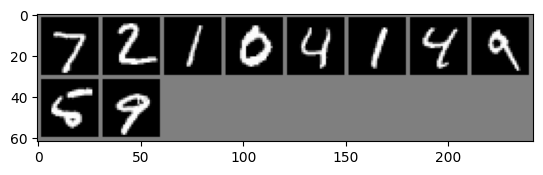

7     2     1     0     4     1     4     9     5     9    


In [6]:
def imshow(img):
    npimg = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

n_show = 10
imshow(torchvision.utils.make_grid(images[:n_show]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(min(n_show, BATCHSIZE))))

## GAN

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)  # GAN hack
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.fc4(x)

        return x


class Generator(nn.Module):

    def __init__(self, **kwargs):
        super(Generator, self).__init__()

        n_hiddens = kwargs['n_hiddens']

        self.fc1 = nn.Linear(n_hiddens, 256)
        self.bn1 = nn.BatchNorm1d(256)  # does not work without these batchnorm
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 28*28)
        self.bn4 = nn.BatchNorm1d(28*28)

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc4(x)
        x = self.bn4(x)
        x = torch.tanh(x)

        x = torch.reshape(x, (-1, 1, 28, 28))

        return x
    

net_disc = Discriminator()
net_gen = Generator(n_hiddens=N_HIDDENS)

net_disc.to(device)
net_gen.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_disc = optim.Adam(
    net_disc.parameters(),
    lr=LR,
)
optimizer_gen = optim.Adam(
    net_gen.parameters(),
    lr=LR,
)

net_disc(torch.randn(4, 1, 28, 28).to(device))
net_gen(torch.randn(4, N_HIDDENS).to(device))

net_disc, net_gen

(Discriminator(
   (fc1): Linear(in_features=784, out_features=1024, bias=True)
   (fc2): Linear(in_features=1024, out_features=512, bias=True)
   (fc3): Linear(in_features=512, out_features=256, bias=True)
   (fc4): Linear(in_features=256, out_features=1, bias=True)
 ),
 Generator(
   (fc1): Linear(in_features=8, out_features=256, bias=True)
   (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc2): Linear(in_features=256, out_features=512, bias=True)
   (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc3): Linear(in_features=512, out_features=1024, bias=True)
   (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc4): Linear(in_features=1024, out_features=784, bias=True)
   (bn4): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ))

In [52]:
def show_generated():
    was_training = net_gen.training
    net_gen.eval()
    with torch.no_grad():        
        noises = torch.randn(10, N_HIDDENS).to(device)
        inputs_fake = net_gen(noises)
        imshow(torchvision.utils.make_grid(inputs_fake.cpu()))
    if was_training:
        net_gen.train()

[200, 400] loss_disc: 0.352, loss_gen: 2.170


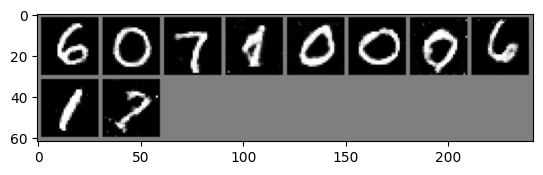

In [9]:
net_disc.train()
net_gen.train()

for epoch in range(EPOCHS):

    clear_output(wait=True)

    running_loss_disc = 0.0
    running_loss_gen = 0.0
    for i, data in enumerate(trainloader):
        
        # discriminator
        inputs_real, _ = data
        inputs_real = inputs_real.to(device)
        labels_real = torch.ones(inputs_real.shape[0], 1).to(device)

        noises = torch.randn(inputs_real.shape[0], N_HIDDENS).to(device)
        inputs_fake = net_gen(noises)
        labels_fake = torch.zeros(inputs_real.shape[0], 1).to(device)
        
        optimizer_disc.zero_grad()

        outputs_real = net_disc(inputs_real)
        loss_real = criterion(outputs_real, labels_real)
        outputs_fake = net_disc(inputs_fake)
        loss_fake = criterion(outputs_fake, labels_fake)

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optimizer_disc.step()

        running_loss_disc += loss.item()

        # generator
        noises = torch.randn(inputs_real.shape[0], N_HIDDENS).to(device)
        inputs_fake = net_gen(noises)
        labels_fake = torch.ones(inputs_real.shape[0], 1).to(device)

        optimizer_gen.zero_grad()
        outputs_fake = net_disc(inputs_fake)
        loss = criterion(outputs_fake, labels_fake)
        loss.backward()
        optimizer_gen.step()
        
        running_loss_gen += loss.item()

        if i % STEP_SIZE == STEP_SIZE - 1:
            print(f'[{epoch + 1}, {i + 1}] loss_disc: {running_loss_disc / STEP_SIZE:.3f}, loss_gen: {running_loss_gen / STEP_SIZE:.3f}')
            running_loss_disc = 0.0
            running_loss_gen = 0.0
            show_generated()

Personal experience:
1. Should have BatchNorm in the generator. Can have less layers (in both generator and discriminator), but should have a BatchNorm after every layer of the generator.
2. Dropout is not necessary.
3. Learning rate should be small.
4. The number of learning steps for the discriminator and the generator should be the same.
5. The loss of the generator should be bigger than the loss of the discriminator.
6. Backward of the discriminator separately for real versus fake data seems to make the generator be biased towards 1, 4, 7, 9.

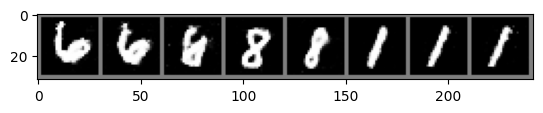

In [88]:
# gradually change one components of the noise
component = [3, 4, 5]
num = 8
net_gen.eval()
with torch.no_grad():
    noise = torch.randn(N_HIDDENS)
    noise = noise.repeat(num, 1)
    noise[:, component] = torch.linspace(-2, 2, num * len(component)).reshape(num, len(component))
    noise = noise.to(device)
    img_gen = net_gen(noise)
    img_gen = img_gen.cpu()
    imshow(torchvision.utils.make_grid(img_gen))

## References

1. https://freedium.cfd/https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
2. https://github.com/soumith/ganhacks